In [6]:
%matplotlib inline

import matplotlib.pyplot as plt

In [7]:
from datetime import timedelta, datetime

import numpy as np
import yfinance as yf



from optfolio.optimize import Optimizer


In [8]:
import yfinance as yf

In [12]:
PERIOD = '10y'
TICKERS = [
    # Internet services
    'msft',
    'goog',

#     'twtr',
    'vmw',
#     'orcl',
#     'bidu',
    'spot',
    # Application software
    'shop',
    'adbe',
    'crm',
#     'wday',
#     'sap',
    'sq',
    'team',
    # Comm. equipment
#     'csco',
    # Semiconductors
    'intc',
    'amd',
    'txn',
# #     'qcom',
    'nvda',
    # Misc
#     'dell',
    # Personal finance
    'v',
    'ma',

    # Consumer directionary
    'aapl',
    'nke',
#     'ads',
#     'sne',
    'amzn',
#     'ebay',
#     'baba',
    # Aerospace
    'lmt',
    'noc',
#     'ba',
    # Media
    'nflx',
    'dis',
    # Airlines
    'dal',
    'ual',
#     'luv',
    # Automotive
    'tsla'
]

def fetch_data(ticker):
    try:
        data = yf.download(
            tickers=ticker,
            period=PERIOD,
            interval='1d',
            auto_adjust=True,
            prepost=False,
            group_by='ticker'
        ).dropna(axis=1, how='all')
        return data
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

# Assuming TICKERS is a list
all_data = {}
for ticker in TICKERS:
    data = fetch_data(ticker)
    if data is not None:
        all_data[ticker] = data

# Combine all dataframes
import pandas as pd
data = pd.concat(all_data, axis=1)

# Calculate daily returns if 'Close' column exists
if 'Close' in data.columns:
    daily_returns = (data['Close'] / data['Close'].shift(1) - 1)[1:]
    print(daily_returns.head())
else:
    print("Close column not found!")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [16]:
# Filter out columns where the second level is 'Close'
close_columns = [col for col in data.columns if col[1] == 'Close']

# Extract just the 'Close' columns for all stocks
close_data = data[close_columns]

# Calculate daily returns for 'Close' prices of each stock
daily_returns = close_data.pct_change().dropna()

print(daily_returns.head())



                msft      goog       vmw      spot      shop      adbe  \
               Close     Close     Close     Close     Close     Close   
Date                                                                     
2018-04-04  0.029205  0.011575  0.016351 -0.032145  0.010891  0.042236   
2018-04-05  0.000541  0.002605 -0.000164 -0.001595 -0.004392 -0.006710   
2018-04-06 -0.023273 -0.020208 -0.025942  0.027294 -0.022640 -0.022054   
2018-04-09  0.005984  0.008351  0.015339  0.014062  0.013030  0.002562   
2018-04-10  0.023246  0.015944  0.010625  0.032667  0.032955  0.024456   

                 crm        sq      team      intc  ...      aapl       nke  \
               Close     Close     Close     Close  ...     Close     Close   
Date                                                ...                       
2018-04-04  0.025667  0.001891  0.054501  0.004824  ...  0.019122  0.025787   
2018-04-05 -0.003683  0.007342 -0.002495  0.007802  ...  0.006934  0.017100   
2018-04-06 -

## Stocks

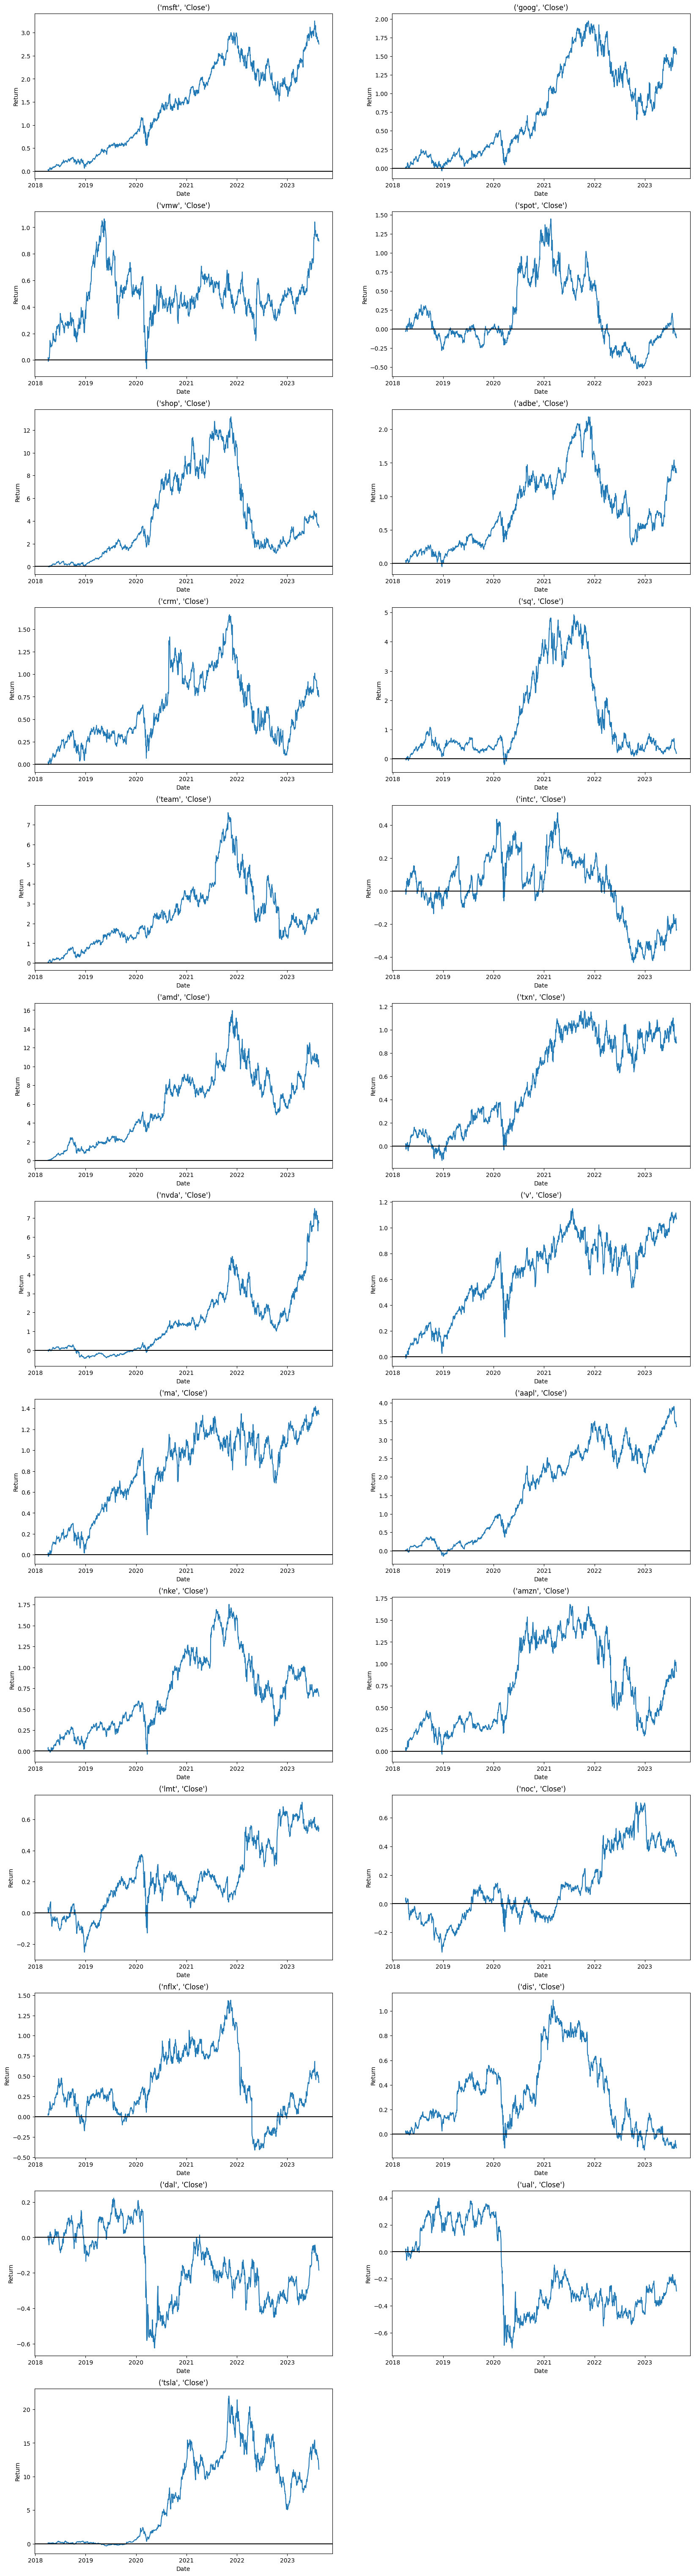

In [17]:
n_rows = int(np.ceil(daily_returns.shape[1] / 2.0))
plt.figure(figsize=(20, n_rows * 6))
for i, ticker in enumerate(daily_returns.columns):
    plt.subplot(n_rows, 2, i + 1)
    plt.title(ticker)
    plt.plot(np.cumprod(daily_returns[ticker] + 1) - 1)
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.axhline(0, color='black')
plt.show()

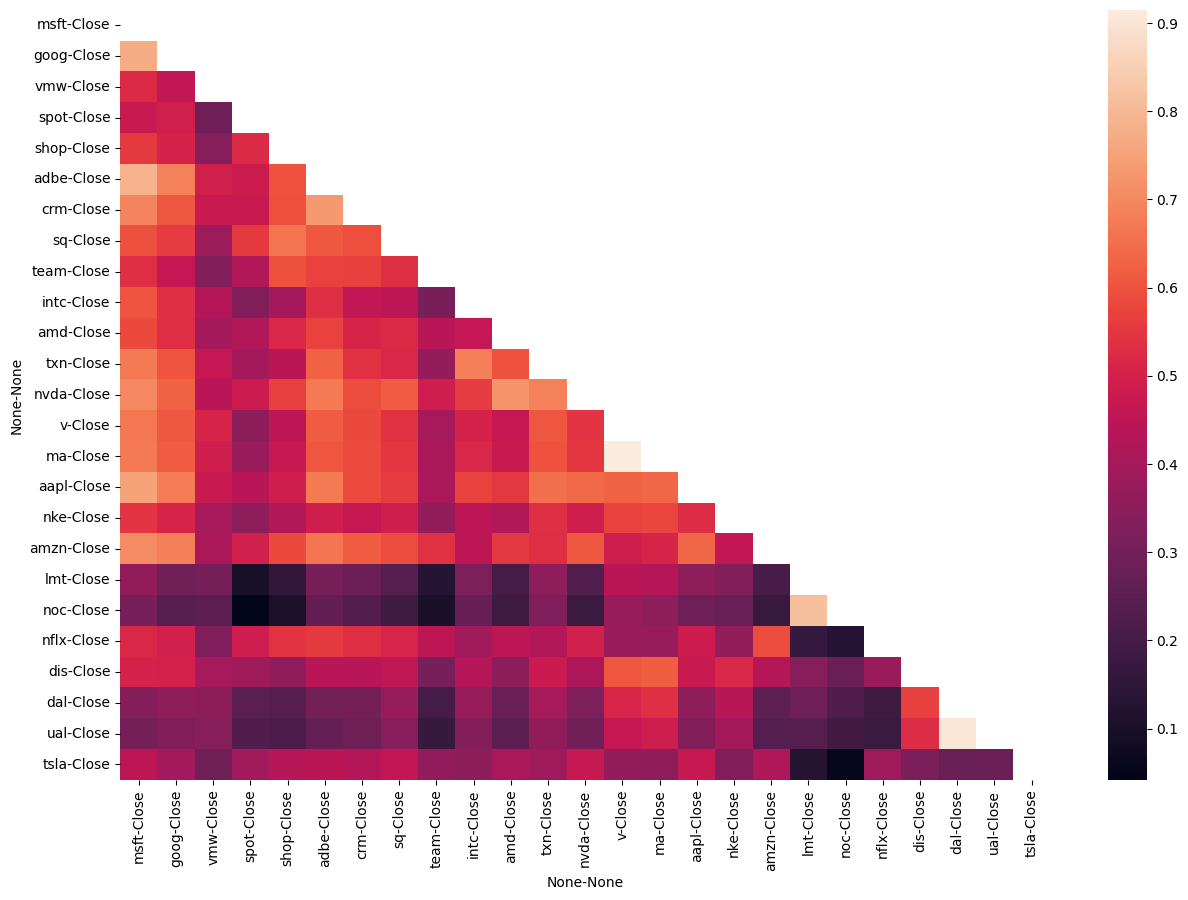

In [18]:
import seaborn as sns

plt.figure(figsize=(15,10))
cm = daily_returns.corr()
mask = (1 - np.tril(np.ones_like(cm))) == 1
cm[np.eye(cm.shape[0]) == 1] = np.nan
cm[mask] = np.nan
# cm[cm <= 0.5] = np.nan
sns.heatmap(cm)
plt.show()

In [19]:
spy_data = yf.download(tickers='SPY', period=PERIOD, interval='1d', auto_adjust=True, prepost=False)
spy_daily_returns = (spy_data['Close'] / spy_data['Close'].shift(1) - 1)[1:]
spy_daily_returns.head()

[*********************100%%**********************]  1 of 1 completed


Date
2013-08-20    0.004916
2013-08-21   -0.006160
2013-08-22    0.009115
2013-08-23    0.003372
2013-08-26   -0.003721
Name: Close, dtype: float64

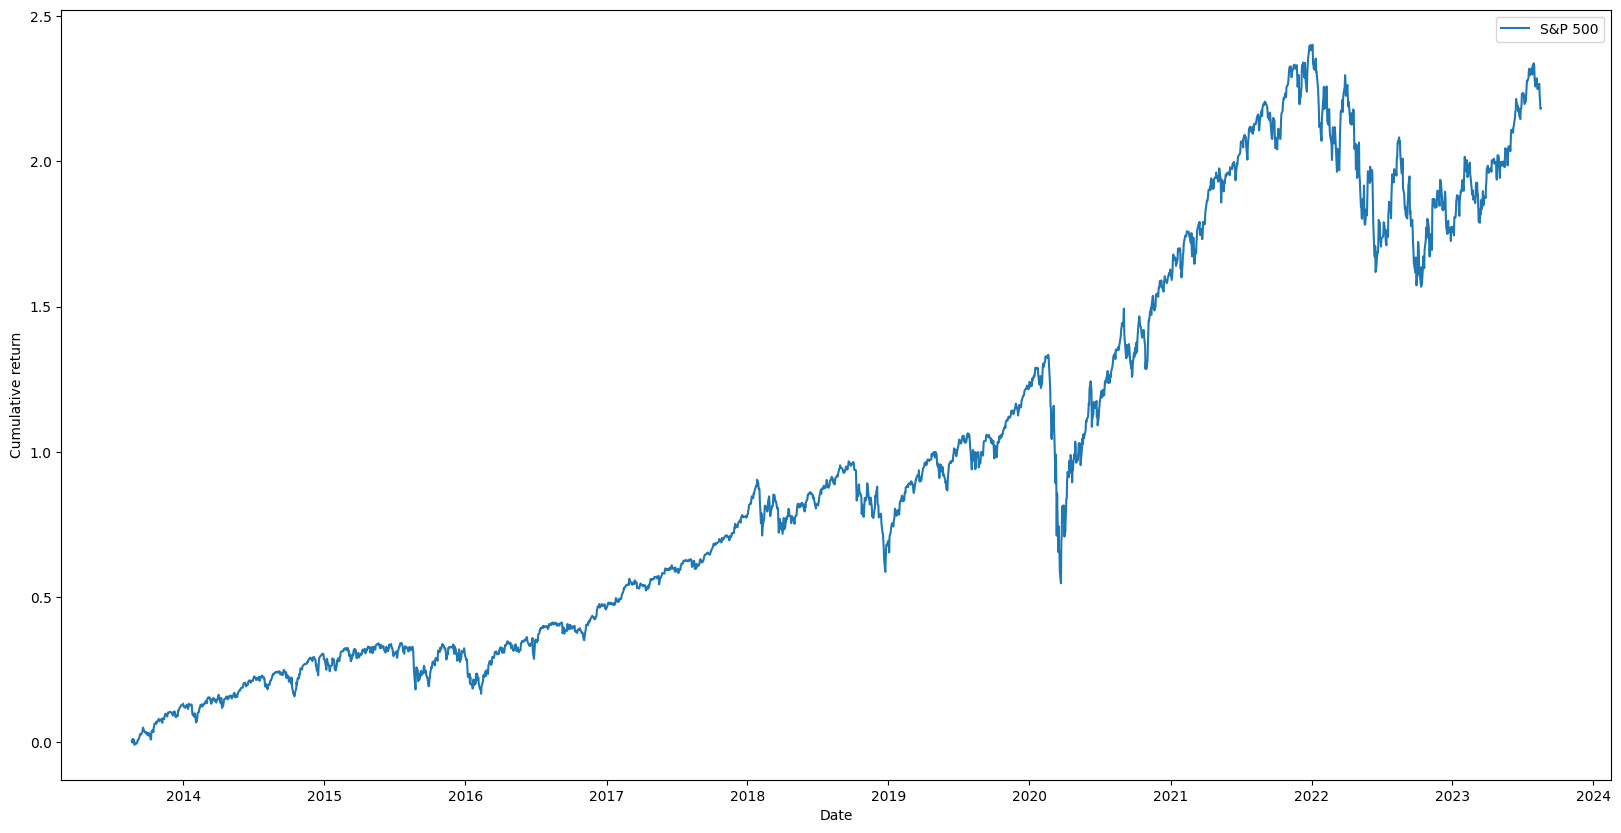

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(np.cumprod(spy_daily_returns + 1) - 1, label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.legend()
plt.show()

## Optimization

In [21]:
YEAR_BARS = 252
TEST_YEARS = 0
TRAIN_END_DATE = data.index.max() - timedelta(days=TEST_YEARS * 365)
train = daily_returns[(daily_returns.index < TRAIN_END_DATE)].fillna(0)
test = daily_returns[(daily_returns.index >= TRAIN_END_DATE)].fillna(0)

spy_train = spy_daily_returns[(spy_daily_returns.index < TRAIN_END_DATE)].fillna(0)
spy_test = spy_daily_returns[(spy_daily_returns.index >= TRAIN_END_DATE)].fillna(0)

print(np.any(np.isnan(train)))
print(train.shape)
train.tail()

False
(1353, 25)


,msft,goog,vmw,spot,shop,adbe,crm,sq,team,intc,...,aapl,nke,amzn,lmt,noc,nflx,dis,dal,ual,tsla
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-11,-0.005946,-0.000307,-0.007543,0.016492,-0.021250,-0.014307,0.002161,-0.026832,0.000962,0.006055,...,0.000338,-0.008622,-0.001083,0.008888,0.001813,-0.019350,-0.029861,-0.015381,-0.013031,-0.010964
2023-08-14,0.009439,0.012753,0.007665,0.005048,0.012846,0.027141,0.016100,-0.006934,0.011181,0.022643,...,0.009393,-0.004163,0.015606,-0.008744,-0.003712,0.014514,-0.002359,0.001358,0.000957,-0.011910
2023-08-15,-0.006728,-0.011833,-0.002685,-0.042689,-0.011433,-0.006797,-0.015467,-0.029759,-0.033722,-0.025504,...,-0.011200,-0.010126,-0.020630,-0.014442,-0.014623,-0.009538,-0.019705,-0.027357,-0.018543,-0.028362
2023-08-16,-0.002428,-0.008905,-0.001602,0.006895,0.000000,-0.008116,-0.008574,-0.014907,-0.031896,-0.035663,...,-0.004959,-0.000188,-0.018886,0.003494,0.009736,-0.019471,-0.008155,-0.008136,-0.012076,-0.031593
2023-08-17,-0.010986,0.010456,-0.002118,-0.020692,-0.038309,-0.005481,-0.015218,-0.024178,-0.008718,-0.028333,...,-0.014555,-0.013893,-0.008070,0.003482,0.004400,-0.029968,-0.004980,-0.020858,-0.023462,-0.028280


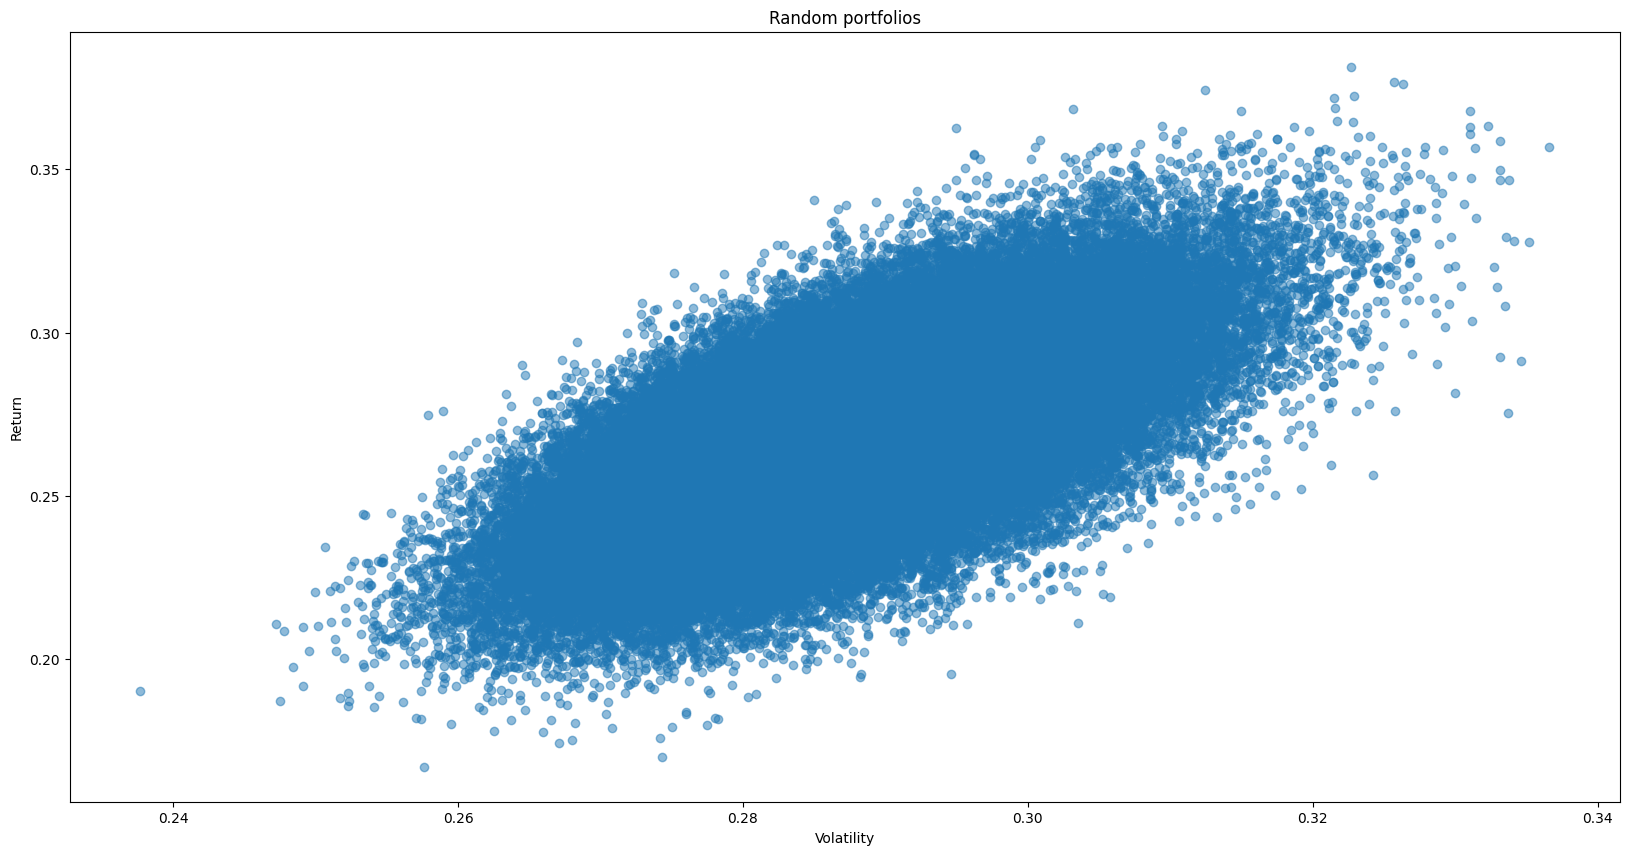

In [22]:
def random_population(n_assets, population_size):
    weights = np.random.uniform(0, 1, size=(population_size, n_assets))

    return weights / weights.sum(axis=-1).reshape((-1, 1))

def annualized_portfolio_return(returns, weights):
    weighted_returns = np.matmul(weights, np.mean(returns.values, 0))

    return (weighted_returns + 1) ** YEAR_BARS - 1


def annualized_portfolio_volatility(returns, weights):
    variance = np.sum(weights * np.matmul(weights, np.cov(returns.T.values)), -1)

    return np.sqrt(variance) * np.sqrt(YEAR_BARS)


def annualized_portfolio_performance(returns, weights):
    return np.stack([
        annualized_portfolio_return(returns, weights),
        annualized_portfolio_volatility(returns, weights)
    ], -1)

rand_weights = random_population(train.shape[1], 100000)
rand_solutions = annualized_portfolio_performance(train, rand_weights)

plt.figure(figsize=(20,10))
plt.title('Random portfolios')
plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

In [23]:
optimizer = Optimizer(mutation_sigma=1.0, verbose=False, max_iter=250, population_size=5000)
solutions, stats = optimizer.run(train.values)

In [24]:
solutions.shape

(341, 25)

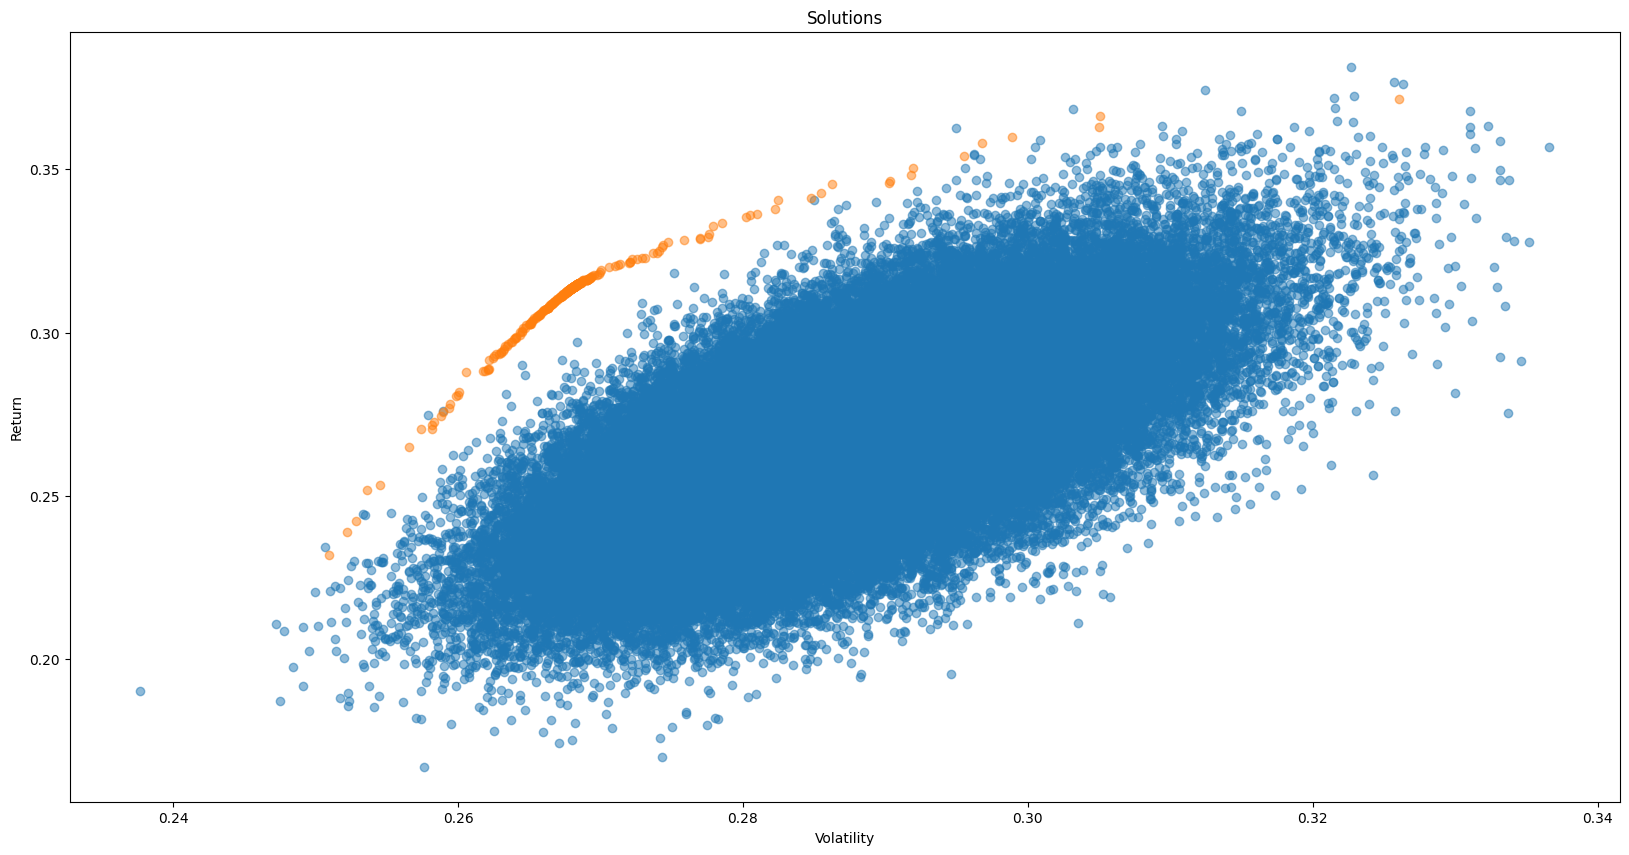

In [25]:
def plot_solutions(data, solutions, rand_solutions):
    ov = annualized_portfolio_performance(data, solutions)
    plt.figure(figsize=(20,10))
    plt.title('Solutions')
    plt.scatter(rand_solutions[:,1], rand_solutions[:,0], alpha=.5)
    plt.scatter(ov[:,1], ov[:,0], alpha=.5)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()

plot_solutions(train, solutions, rand_solutions)

In [26]:
ov = annualized_portfolio_performance(train, solutions)
sharpe = ov[:,0] / ov[:,1]
# solution = solutions[np.argmin(np.abs(ov[:,1] - 0.16))]
solution = solutions[np.argmax(ov[:,0] / ov[:,1])]
annualized_portfolio_performance(train, solution)

array([0.3582093 , 0.29680916])

In [28]:
CAPITAL = 38000

def print_allocation(data, allocations, prices):
    # Adjust the ticker extraction from the multi-level column
    tickers = [col[0] for col in data.columns if col[1] == 'Close']

    for ticker_id in np.argsort(-allocations):
        ticker = tickers[ticker_id]
        allocation_amt = CAPITAL * allocations[ticker_id]
        ticker_price = prices[ticker]
        shares = allocation_amt / ticker_price

        print('%s - %.4f, $%.2f USD, %.2f shares' % (ticker, allocations[ticker_id] * 100, allocation_amt, shares))

# Extract the 'Close' prices correctly from the multi-level columns
close_prices = data.xs('Close', level=1, axis=1).iloc[-1]

print_allocation(train, solution, close_prices)


amd - 8.6285, $3278.82 USD, 31.09 shares
tsla - 8.0996, $3077.85 USD, 14.28 shares
team - 7.9675, $3027.66 USD, 16.25 shares
msft - 7.6024, $2888.91 USD, 9.13 shares
vmw - 6.9059, $2624.23 USD, 16.94 shares
aapl - 6.8335, $2596.74 USD, 14.88 shares
lmt - 6.2336, $2368.77 USD, 5.26 shares
nvda - 6.2270, $2366.26 USD, 5.46 shares
v - 4.3260, $1643.88 USD, 6.90 shares
shop - 4.2581, $1618.10 USD, 30.45 shares
nke - 3.5400, $1345.20 USD, 12.83 shares
spot - 3.2929, $1251.30 USD, 9.49 shares
dal - 3.2495, $1234.80 USD, 29.76 shares
ma - 3.0076, $1142.90 USD, 2.91 shares
ual - 2.4664, $937.22 USD, 19.09 shares
dis - 2.4650, $936.69 USD, 10.90 shares
amzn - 2.4349, $925.27 USD, 6.95 shares
adbe - 2.3086, $877.27 USD, 1.73 shares
intc - 2.2799, $866.36 USD, 26.45 shares
noc - 2.0677, $785.73 USD, 1.83 shares
txn - 1.7194, $653.38 USD, 3.92 shares
nflx - 1.2101, $459.83 USD, 1.14 shares
sq - 0.9669, $367.41 USD, 6.46 shares
crm - 0.9568, $363.58 USD, 1.78 shares
goog - 0.9542, $362.58 USD, 2.83

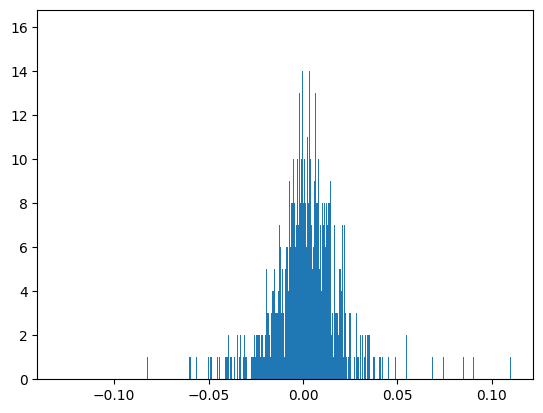

In [30]:
ret = np.dot(train, solution)
plt.hist(ret, bins=1000)
plt.show()

In [31]:
from optfolio.returns_projection import cumulative_n_period_returns, sample_returns, mcmc_sample_returns
from optfolio.report import plot_traces, returns_table

### S&P 500 MC Projection

In [32]:
print("Annualized return: %.6f" % (np.mean(spy_train + 1) ** 252 - 1))
print("Annualized volatility: %.6f" % (np.sqrt(np.var(spy_train) * 252)))

Annualized return: 0.140240
Annualized volatility: 0.174751


In [33]:
spy_traces = sample_returns(spy_train, 10 * 252, n_traces=100000)

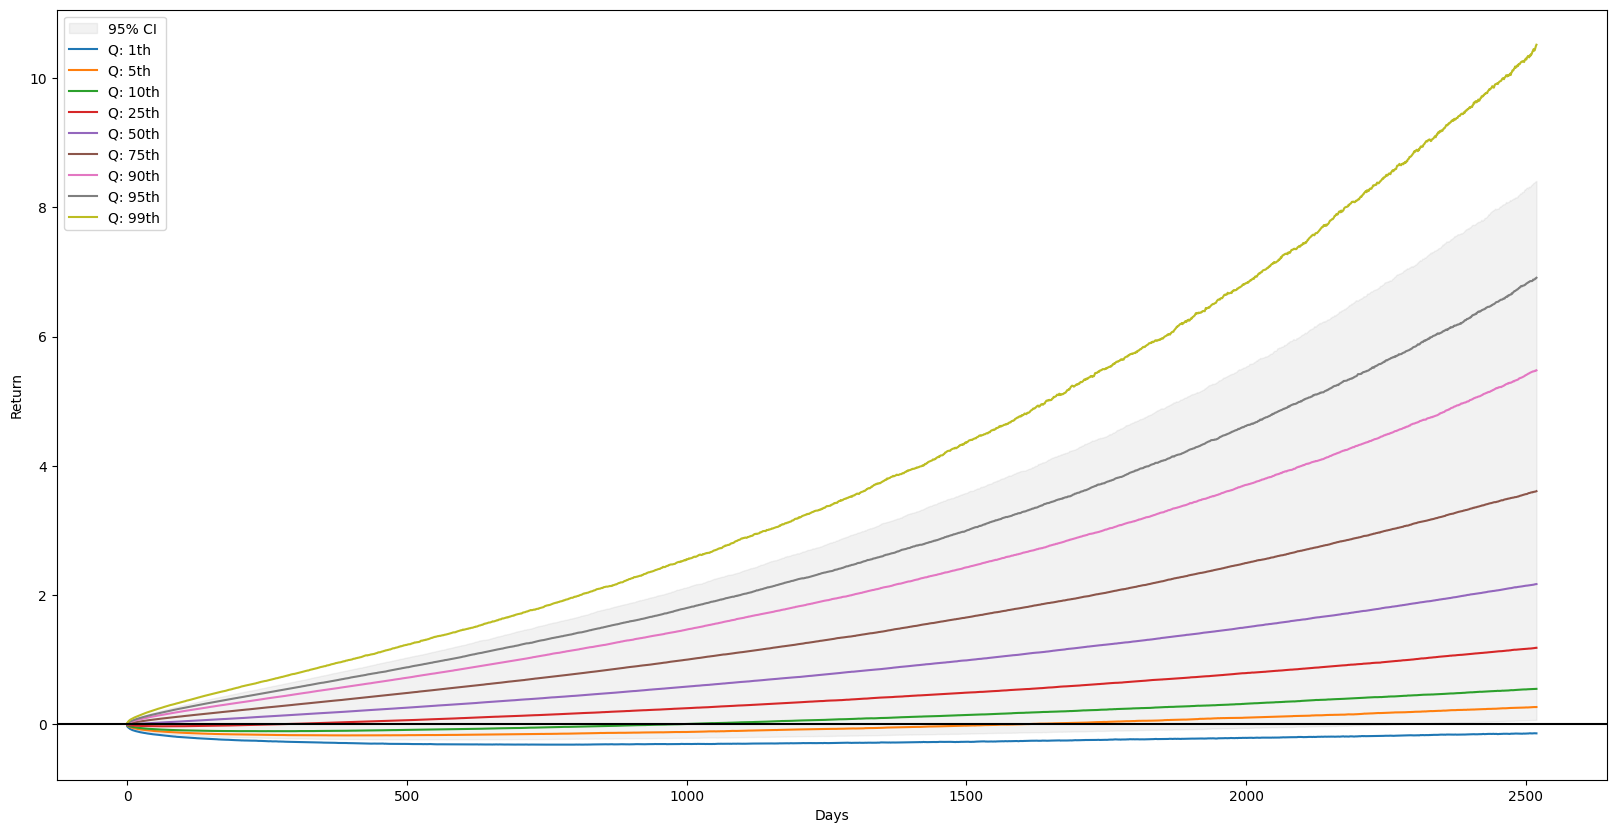

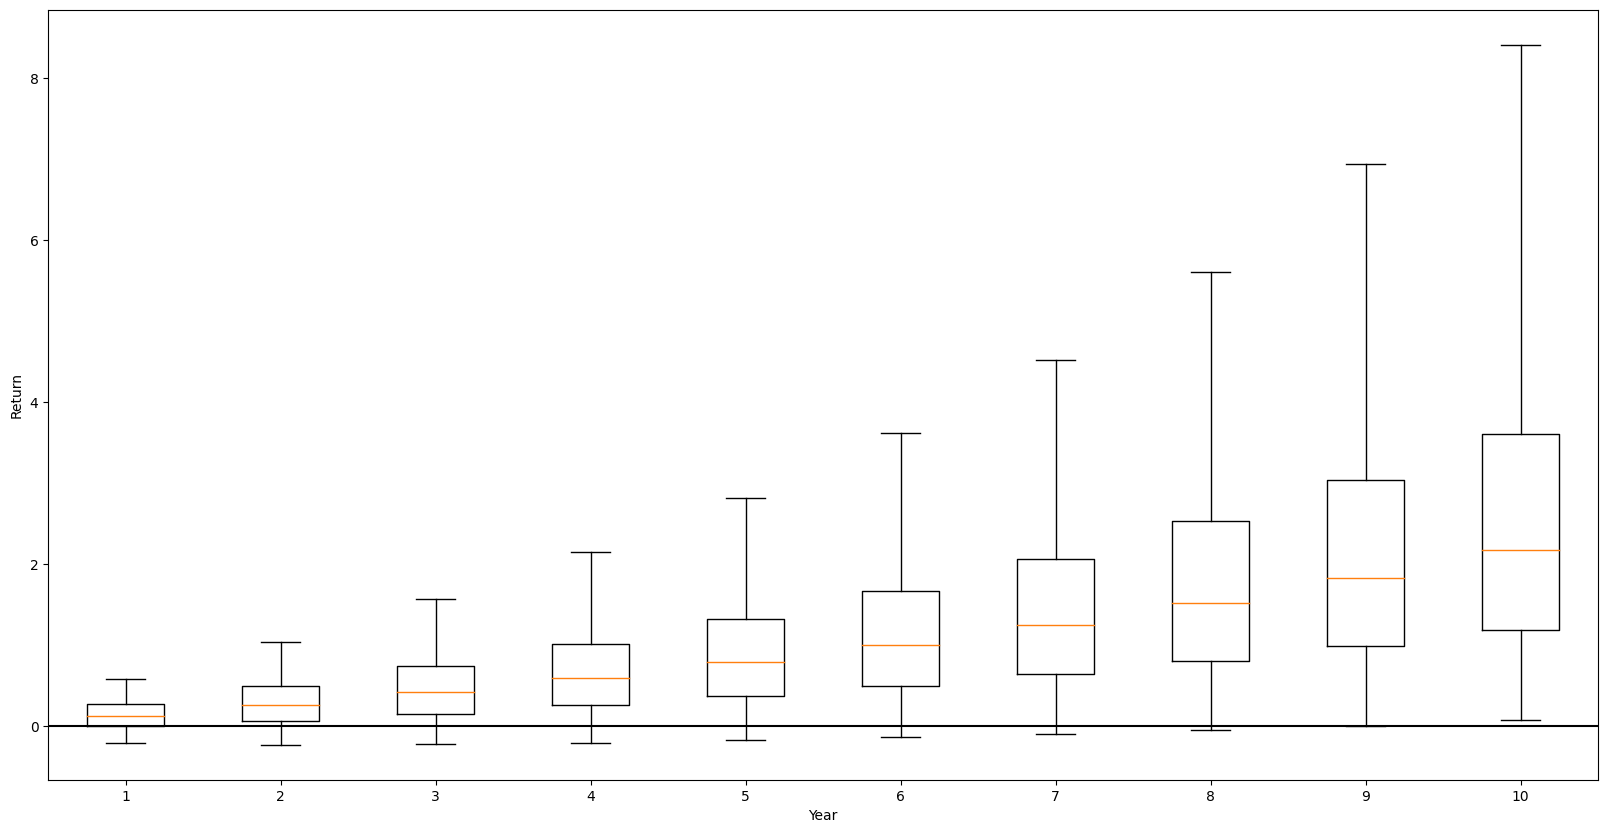

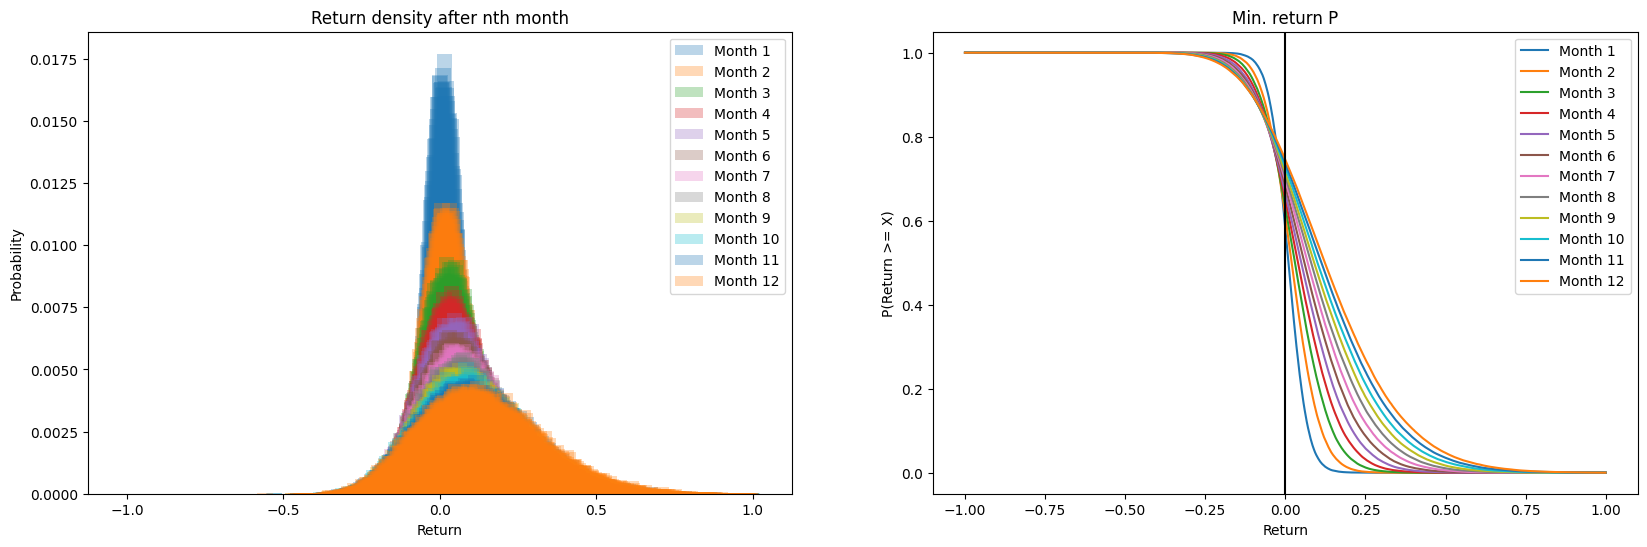

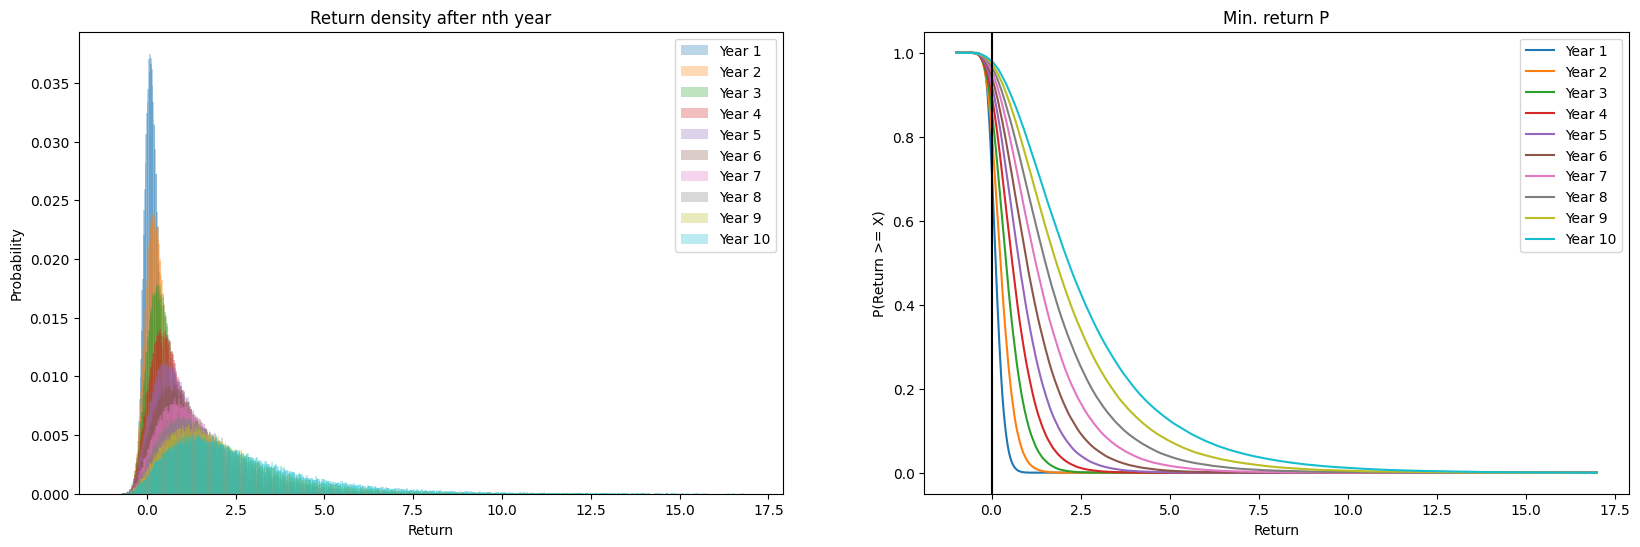

,< 0,> 0,>= 1,>= 2,>= 3,>= 4,>= 5,>= 6,>= 7,>= 8,>= 9,>= 10
Year,,,,,,,,,,,,
1,25.222,74.778,0.044,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,17.564,82.436,3.010,0.018,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,12.814,87.186,12.575,0.622,0.027,0.001,0.000,0.000,0.000,0.000,0.000,0.000
4,9.545,90.455,25.480,3.382,0.396,0.048,0.009,0.002,0.001,0.000,0.000,0.000
5,7.173,92.827,38.474,9.074,1.882,0.401,0.096,0.023,0.005,0.000,0.000,0.000
6,5.402,94.598,50.118,17.239,5.200,1.590,0.482,0.184,0.063,0.025,0.006,0.001
7,4.103,95.897,59.904,26.483,10.478,4.093,1.653,0.681,0.297,0.135,0.064,0.028
8,3.159,96.841,68.023,36.263,17.548,8.283,3.922,1.939,0.935,0.485,0.266,0.152
9,2.483,97.517,74.461,45.608,25.465,13.877,7.603,4.215,2.413,1.385,0.796,0.490


In [34]:
spy_cum_returns = plot_traces(spy_traces)
returns_table(spy_cum_returns)

### MC Projection

In [35]:
traces = sample_returns(ret, 10 * 252, n_traces = 100000)

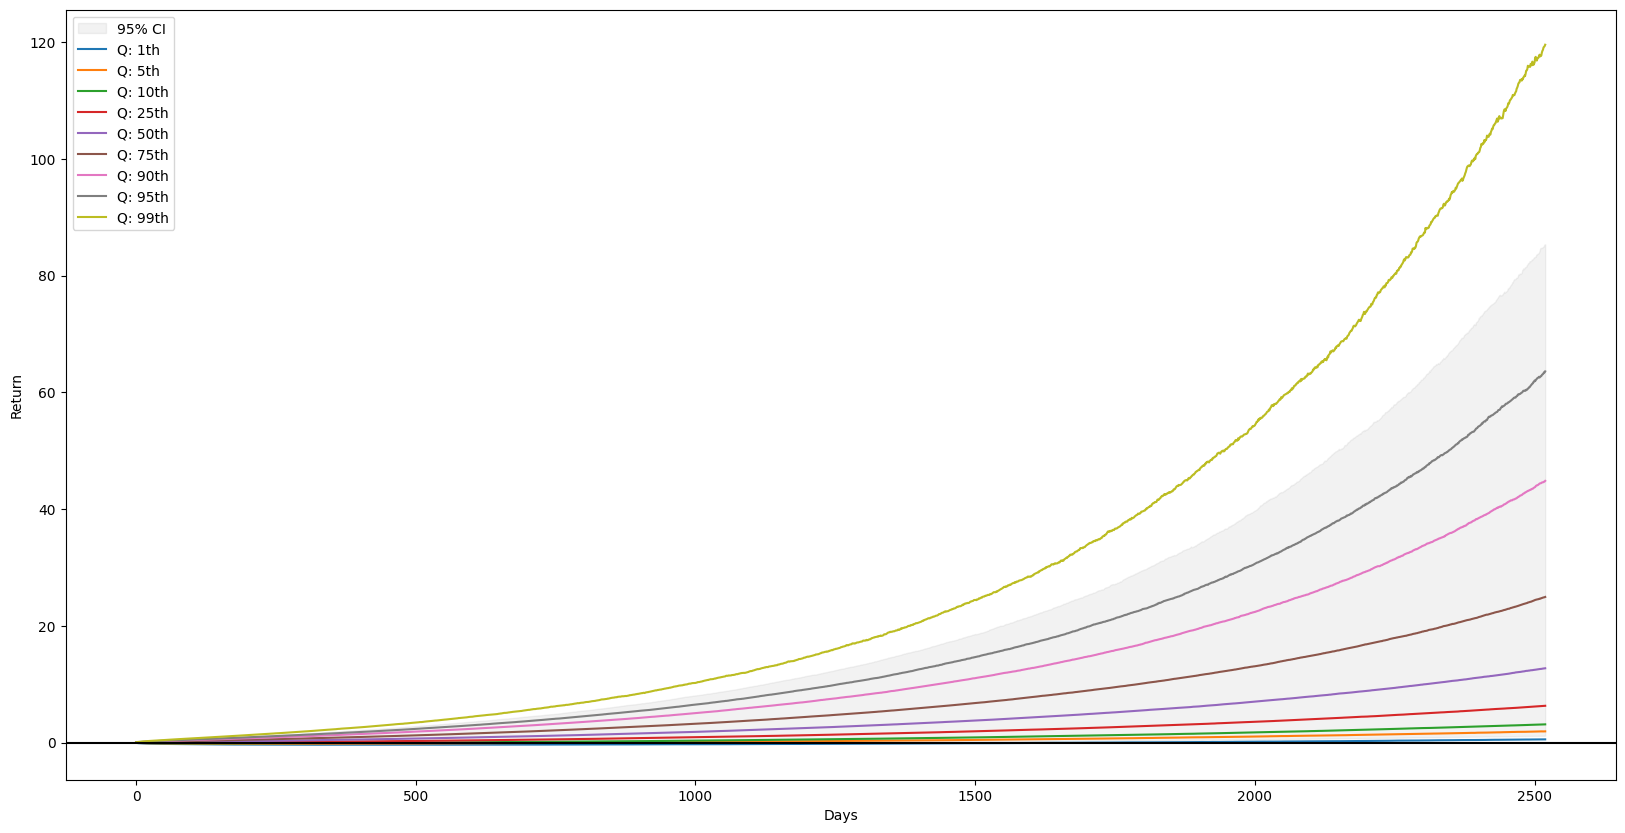

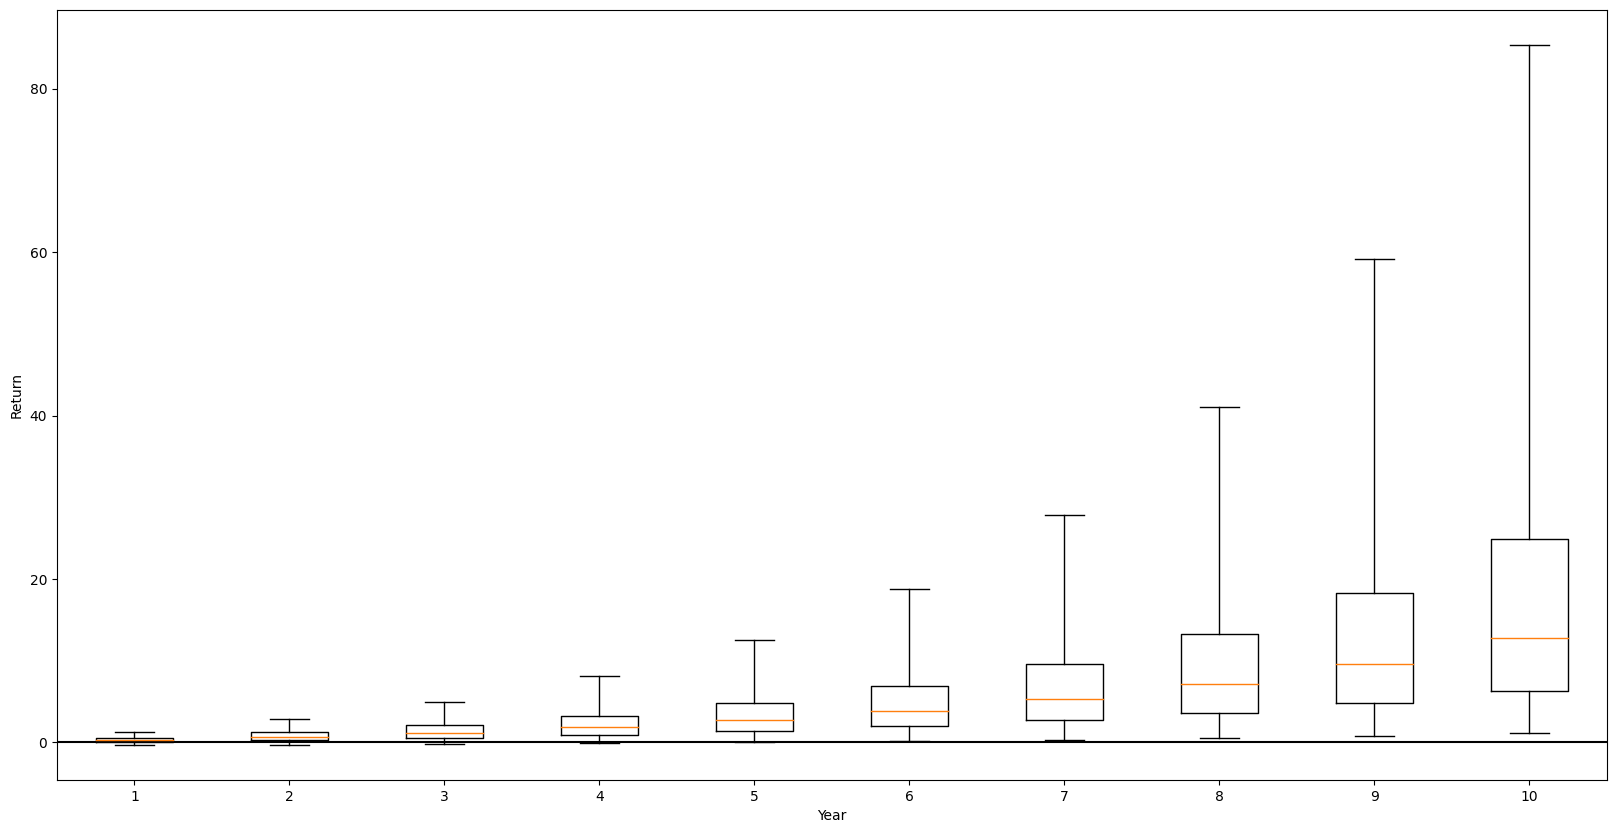

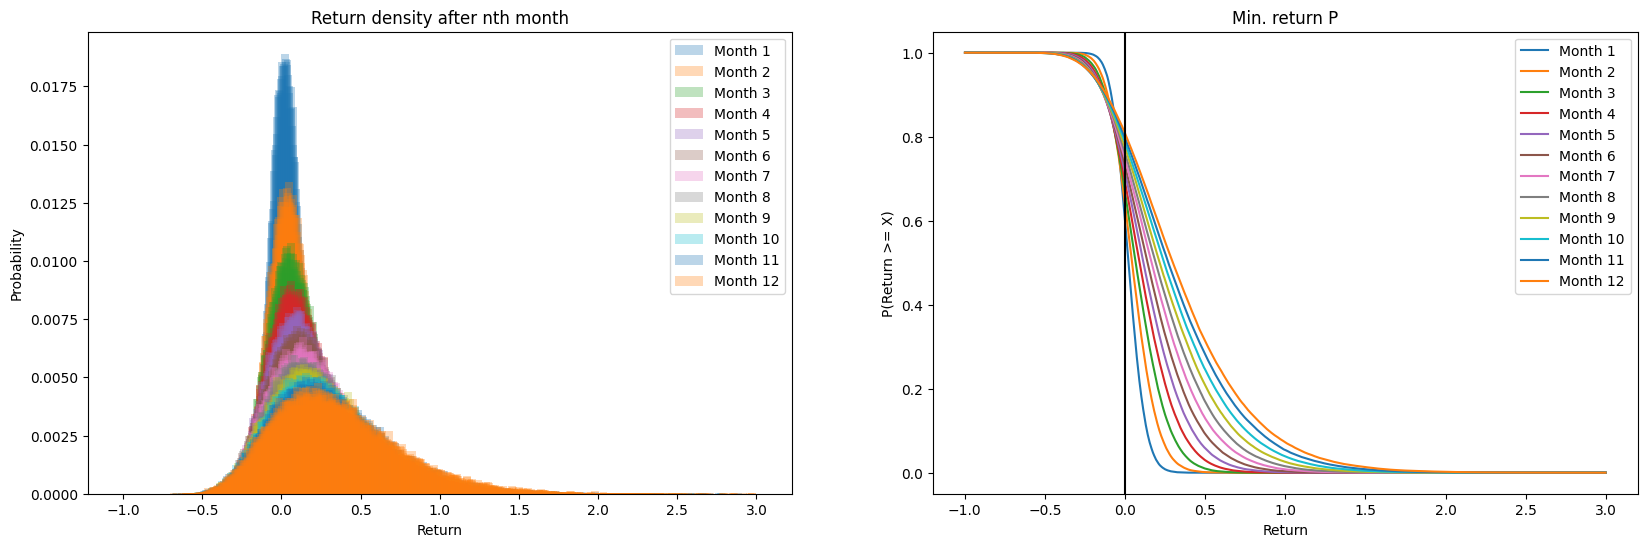

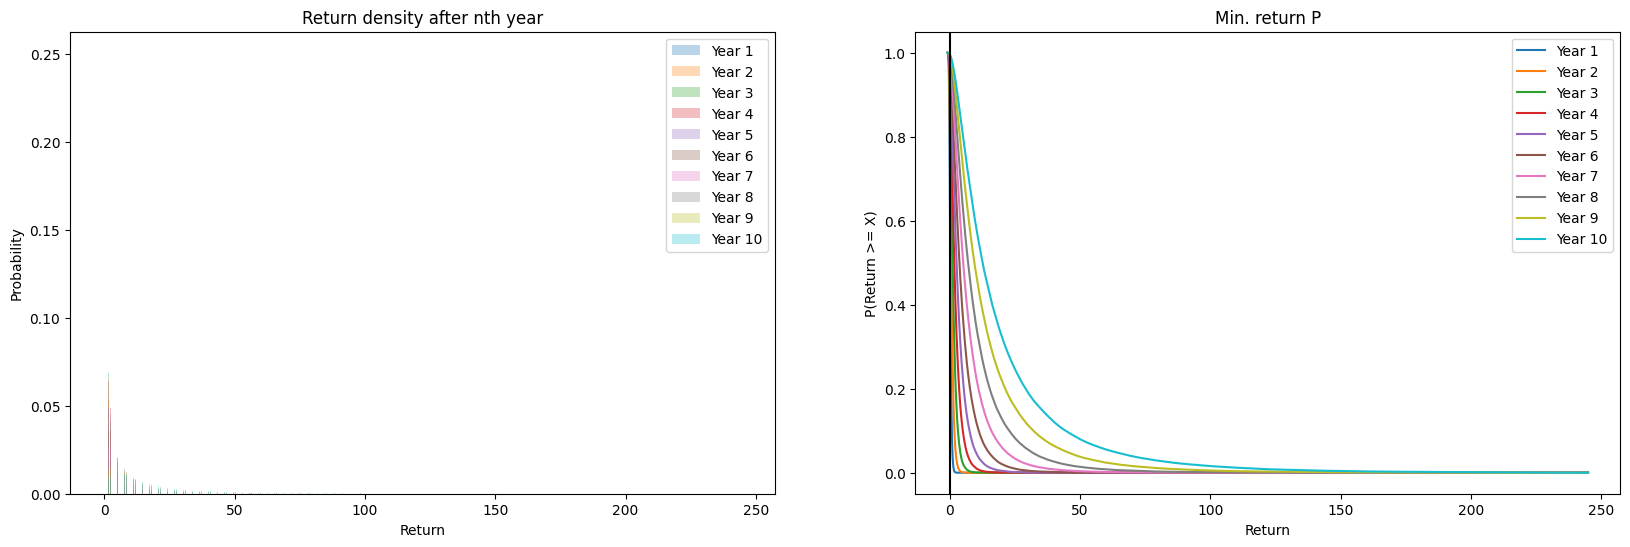

,< 0,> 0,>= 1,>= 2,>= 3,>= 4,>= 5,>= 6,>= 7,>= 8,>= 9,>= 10
Year,,,,,,,,,,,,
1,18.978,81.022,7.295,0.222,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,10.649,89.351,34.211,8.488,1.959,0.464,0.124,0.038,0.012,0.003,0.000,0.000
3,6.416,93.584,57.184,27.251,12.167,5.475,2.473,1.225,0.581,0.287,0.141,0.071
4,3.858,96.142,72.470,46.629,28.493,17.182,10.552,6.562,4.154,2.691,1.780,1.180
5,2.402,97.598,82.525,62.689,45.488,32.625,23.467,16.861,12.276,9.058,6.658,5.046
6,1.508,98.492,88.596,74.293,60.240,47.988,38.245,30.486,24.240,19.506,15.790,12.804
7,0.950,99.050,92.653,82.534,71.489,61.286,52.253,44.493,37.891,32.292,27.663,23.623
8,0.642,99.358,95.291,88.264,80.087,71.909,64.069,56.974,50.764,45.223,40.324,35.944
9,0.406,99.594,96.902,92.120,86.279,79.980,73.801,67.771,62.176,57.067,52.385,48.230


In [36]:
cum_returns = plot_traces(traces)
returns_table(cum_returns)

### MCMC Projection

In [ ]:
mcmc_traces = mcmc_sample_returns(ret, 10 * 252, n_traces=100000, mc_states = 10, n_jobs=10)

In [ ]:
mcmc_cum_returns = plot_traces(mcmc_traces)
returns_table(mcmc_cum_returns)